<a href="https://colab.research.google.com/github/tyfmanlapaz/Data-Science/blob/deep-learning/FINAL_Pneumonia_Classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluating the efficacy of a Conventional CNN model and Pre-trained CNN model on Detecting Pneumonia from Chest X-ray Images**

In this activity, we will be developing a conventional CNN and as well as a pre-trained CNN model for classificying Pneumonia from Chest X-ray images

# 1. Data Collection (Obtain Data)

**1.1 Importing Libraries**

In [ ]:
# load libraries
import pandas as pd
import numpy as np
import random
import os
import glob
from google.colab import drive
import itertools
from PIL import Image

# plotting libraries
import seaborn as sns
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set() # Setting seaborn as default style even if use only matplotlib

# DL and ML Libraries
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image


# environment seeds for reproducibility
seed_value = 42
from numpy.random import seed
seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)                   # Set the random seed in tensorflow at graph level
os.environ['PYTHONHASHSEED'] = str(seed_value)   # Set the seed for hash based operations in python
os.environ['TF_DETERMINISTIC_OPS'] = '1'         # Set seed for TF operations


pd.options.display.max_colwidth = 100

**1.2 Authenticating and Mounting the Dataset**

In [ ]:
# authenticating and mounting GDrive
drive.mount('/content/drive')

#extracting contents of the zip file and loading it to gcolab
from zipfile import ZipFile

# defining path to zip file
cxr_zip_path = '/content/drive/My Drive/GoogleColab/Datasets/CXR.zip'

# creating directory to extract files
cxr_extract_dir = '/content/datasets'
os.makedirs(cxr_extract_dir, exist_ok=True)

# extract zip files to gcolab storage/directory
with ZipFile(cxr_zip_path, 'r') as cxr_zip_ref:
    cxr_zip_ref.extractall(cxr_extract_dir)

# define main dataset directory
main_dir = cxr_extract_dir

#train, test, val directories
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'val')
test_dir = os.path.join(main_dir, 'test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#file count check
def get_file_counts(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'File Count - {label} : {num_data}')

labels= ['PNEUMONIA','NORMAL']
print('Training: \n' + '+' * 55)
get_file_counts(train_dir,labels)

print('\nValidation: \n' + '+' * 55)
get_file_counts(val_dir,labels)

print('\nTesting: \n' + '+' * 55)
get_file_counts(test_dir,labels)
# Note that there are more images classified as pneumonia than normal images.
# This shows that we have an imbalance in our data. We will fix this imbalance later in this notebook.

Training: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
File Count - PNEUMONIA : 3875
File Count - NORMAL : 1341

Validation: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
File Count - PNEUMONIA : 8
File Count - NORMAL : 8

Testing: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
File Count - PNEUMONIA : 390
File Count - NORMAL : 234


**1.3 Loading the PreSplit Datasets into Dataframes**

In [ ]:
# 1. function to get file paths
def get_file_paths(directory):
    file_paths = []
    # get directory structures
    for rootdir, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(rootdir, file)
            size = os.path.getsize(file_path) / 1024 #in KB
            file_paths.append({'file': file_path, 'size_kb': round(size,3)})
    return file_paths

# 2. function to create dataframes
def generate_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_paths(category_path)
        data.extend(file_sizes)
    df = pd.DataFrame(data)
    return df

#create dataframes
train_df = generate_dataframe(train_dir, labels)
test_df = generate_dataframe(test_dir, labels)
val_df = generate_dataframe(val_dir, labels)

# 3. function get class labels
def get_class_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'
directory_df_dict = {'train': train_df, 'val': val_df, 'test': test_df}

# apply function to get labels
for df in directory_df_dict.values():
    df['label'] = df['file'].apply(get_class_label)

# 4. function get dimensions
def get_file_dimensions(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")

# apply function to get dimensions
for name, df in directory_df_dict.items():
    df['dimensions'] = df['file'].apply(get_file_dimensions)

In [ ]:
# get dataframe shapes
print('Dataset Shapes: \n' + '+' * 55)
print('Train Set (train_dir):',train_df.shape)
print('Test Set (test_dir):',test_df.shape)
print('Validation Set (val_dir): ',val_df.shape)

#note: since the images have only 2 dimensions, then the image is considered greyscale.

Dataset Shapes: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train Set (train_dir): (5216, 4)
Test Set (test_dir): (624, 4)
Validation Set (val_dir):  (16, 4)


In [ ]:
# get sample rows from train dataframe
train_df.sample(5)

,file,size_kb,label,dimensions
1897,/content/datasets/train/PNEUMONIA/person620_bacteria_2492.jpeg,181.704,pneumonia,"(1778, 1295)"
877,/content/datasets/train/PNEUMONIA/person327_bacteria_1509.jpeg,161.494,pneumonia,"(1592, 1056)"
4503,/content/datasets/train/NORMAL/NORMAL2-IM-0899-0001.jpeg,1771.479,normal,"(2427, 2374)"
4725,/content/datasets/train/NORMAL/NORMAL2-IM-0392-0001.jpeg,529.786,normal,"(1546, 1414)"
1595,/content/datasets/train/PNEUMONIA/person31_bacteria_164.jpeg,53.033,pneumonia,"(952, 581)"


In [ ]:
# Understanding Data Labels/Class
print(f'Number of Unique Labels (Class): {train_df.iloc[:,2].nunique()}')
print(f'The Unique Values: {train_df.iloc[:,2].unique()}')

Number of Unique Labels (Class): 2
The Unique Values: ['pneumonia' 'normal']


**1.4 Merge Datasets and Create new Split**

In [ ]:
#merge all datasets
combined_df = pd.concat([train_df, val_df,test_df], ignore_index=True)

# split train and test with a ratio of 70:30
train_df, test_df_full = train_test_split(combined_df, test_size=0.3,
                          stratify = combined_df['label'], random_state=seed_value)
# split test_data with validation data wi
test_df, val_df = train_test_split(test_df_full, test_size=0.5,
                           stratify = test_df_full['label'], random_state=seed_value)

print(f'Combined Dataset Shape: {combined_df.shape}')
print('\n' + '+' * 55)
print('New Train Set:',train_df.shape)
print('New Test Set:',test_df.shape)
print('New Validation Set: ',val_df.shape)

Combined Dataset Shape: (5856, 4)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
New Train Set: (4099, 4)
New Test Set: (878, 4)
New Validation Set:  (879, 4)


**1.4 Visualize Class Distributions**

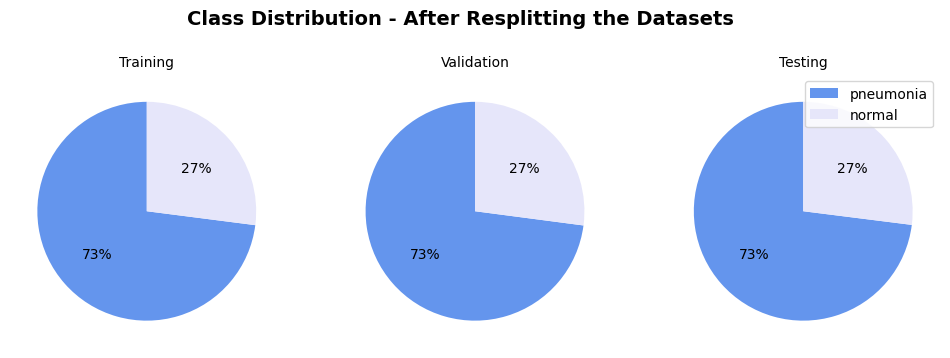

In [ ]:
# Function to create the dataset distribution pie chart plots
def create_distribution_plots(data_dict, title):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  fig.suptitle('Class Distribution - ' + title, fontsize=14, fontweight='bold', ha='center', y=1)
  chart_colors = ['cornflowerblue','lavender']
  #chart_colors = ['orchid', 'lavender']
  subtitle_props = {'fontsize': 10, 'ha': 'center'}
  index = 0

  for split_name, data_name in data_dict.items():

    label_counts = data_name['label'].value_counts() #set labels
    #labels_str = label_counts.index

    # Subplots
    data_wedge = axes[index].pie(label_counts, autopct='%1.0f%%', startangle=90, colors=chart_colors)
    axes[index].set_title(split_name, subtitle_props)
    index = index + 1

  # Create a legend outside the plot using wedges and labels from subplots
  labels = label_counts.index.to_numpy()  # Assuming class labels are in the index
  legend_patches = data_wedge[0]  # Get wedge patches from the first subplot
  plt.legend(legend_patches, labels, loc='upper right', fontsize=10)
  plt.show()

# call function to plot datasets before pre-processing
original_data_dict = {'Training': train_df, 'Validation': val_df, 'Testing': test_df}
create_distribution_plots(original_data_dict, 'After Resplitting the Datasets')

**1.5 Visualize Chest X-Ray Raw Images**

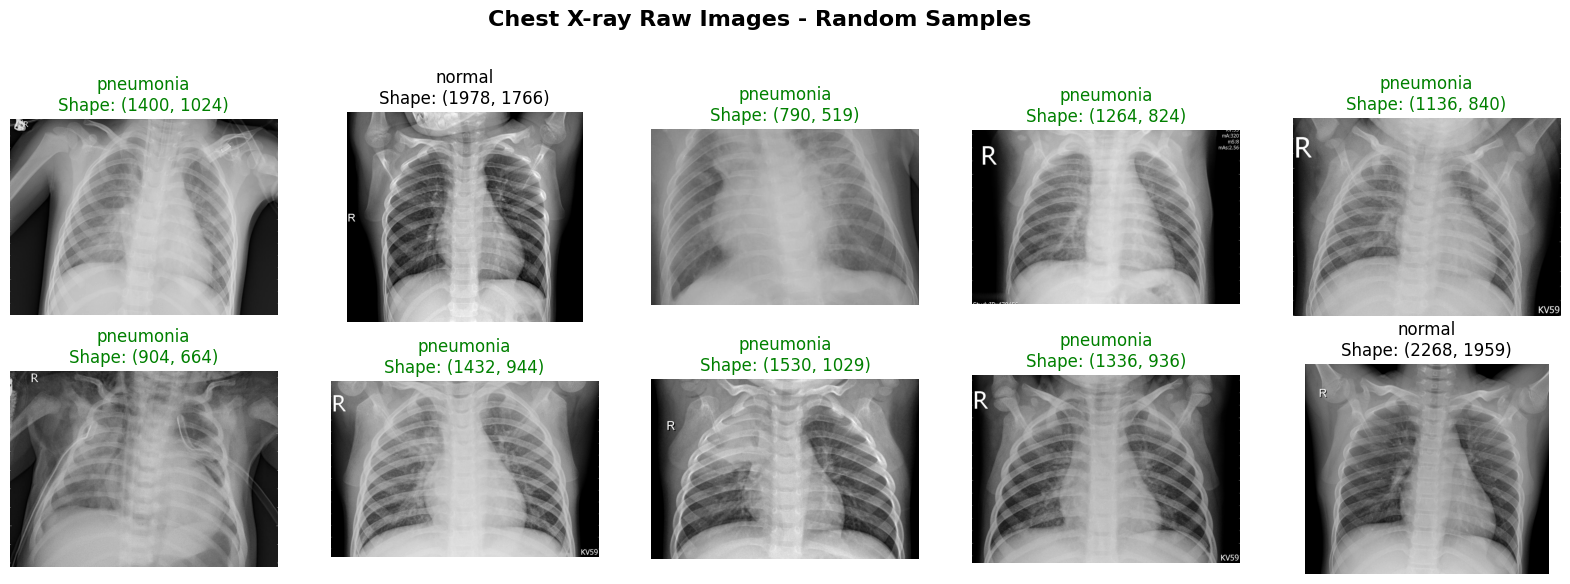

In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 1.5 Visualize Chest X-Ray Raw Images
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# check image shape/dimensions and visualize
rows = 2
columns = 5

sample_dataset = combined_df
random_samples = random.sample(range(len(sample_dataset)), rows * columns)

def plot_sample_images(sample_dataset, random_samples, plot_title):
  fig, axes = plt.subplots(rows, columns, figsize = (20, 6))
  fig.suptitle(f'Chest X-ray Raw Images - {plot_title}', fontsize=16, fontweight='bold', ha='center', y = 1.05)

  for i, index in enumerate(random_samples):
      row = i // columns
      col = i % columns
      img_path = sample_dataset['file'].iloc[index]
      label = sample_dataset['label'].iloc[index]
      img = Image.open(img_path)
      axes[row, col].imshow(img, cmap='gray')
      axes[row, col].axis('off')
      if label == "normal":
        axes[row, col].set_title(f'{label}\nShape: {img.size}', fontsize = 12, ha='center', color='black')
      else:
        axes[row, col].set_title(f'{label}\nShape: {img.size}', fontsize = 12, ha='center', color='green')
  plt.show()
# these image sizes have different dimensions

plot_sample_images(sample_dataset, random_samples, 'Random Samples')

Number of Images less than 10kb: 67


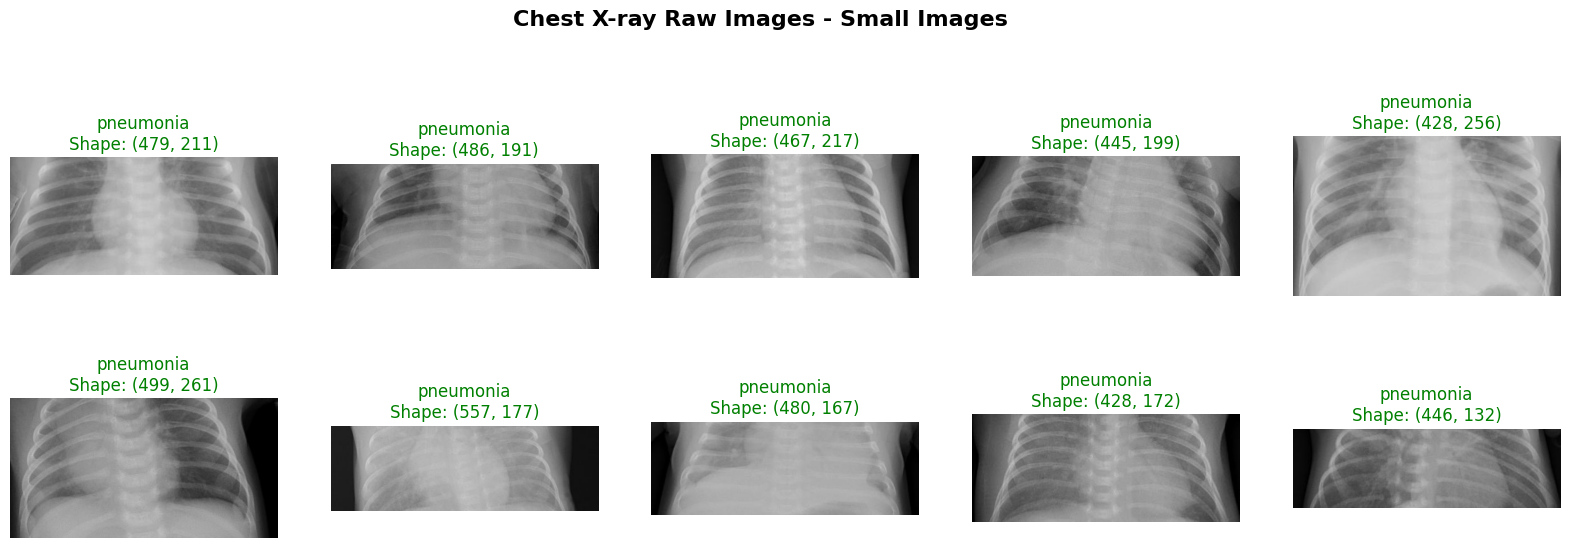

In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 1.6 Determine Optimal Image Size for models
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# checking for file sizes lower than 10kb to determine if we can use 256 or 224
# optimal image size for CNN is 256
# but if we have image dimensions less than 256 then use 224 as this also the optimal size for VGG16
small_images_df = sample_dataset
small_images_df = sample_dataset[(small_images_df['size_kb'] < 12)]
random_samples_small = random.sample(range(len(small_images_df)), rows * columns)

print(f'Number of Images less than 10kb: {len(small_images_df)}')
plot_sample_images(small_images_df, random_samples_small, 'Small Images')
# since we have image heights less than 256, we will use 224 pixels to resize the images

# 2. Data Preprocessing (Scrubbing)

**2.1 Image Preprocessing**


**From the results of the visualization it can be seen that:**

There are some pictures that tend to tilt to the right
or left.
There are some pictures that show hands and chin.
There are some pictures that seem to be cut off, this can be seen with a size below 10 kb.
There are some pictures that are quite bright and dark
Based on these results, in the preprocessing part it seems that we need to augment random rotation, zoom and also maybe we need color jitter.

In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# Setting Constants
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# chooses the best optimization strategies for data processing within data pipeline.
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
image_size = 224  # determined optimal size after iamge size exploration
input_shape= (224, 224, 3)

In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 2.2 Define Image Preprocessing Functions
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
def preprocess_image(file_path, label, channels=3):
    img_data = tf.io.read_file(file_path)

    # Decode the image into a tensor
    img_data = tf.image.decode_jpeg(img_data, channels=channels)
    # Resize the image to a fixed size
    img_data = tf.image.resize(img_data, [image_size, image_size])
    # Normalize pixel values [0, 1]
    img_data = tf.cast(img_data, tf.float32) / 255.0
    #img_data = img_data.astype('float32') / 255.0
    # Convert of labels to numeric (0 for normal, 1 for pneumonia)
    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)
    return img_data, label

def add_color_jitter(image, brightness_factor=0.02, contrast_factor=0.02, seed=None):
  with tf.device('/CPU:0'):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)
    return image

def plot_preprocessed_images(original_img, augmented_img):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original Data')
  plt.imshow(original_img)
  plt.subplot(1,2,2)
  plt.title('Augmented Data')
  plt.imshow(augmented_img)
  plt.axis('off')
  plt.show()

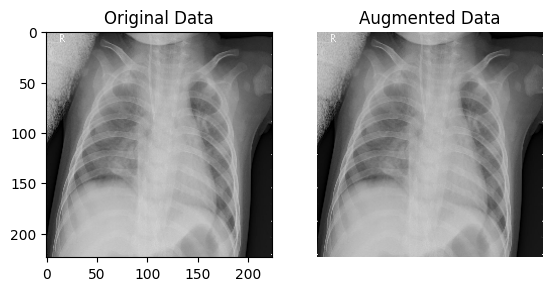

In [ ]:
# get sample pneumonia path
pneumonia_sample_path = train_df.query("label=='pneumonia'")['file'].values
#pneumonia_sample_path

# visualizing a sample of an augmented data
sample_image_path = '/content/datasets/test/PNEUMONIA/person88_bacteria_437.jpeg'
img, label = preprocess_image(sample_image_path,'pneumonia', 3)
color_jiter_test = add_color_jitter(img,seed=seed_value)
plot_preprocessed_images(img, color_jiter_test)

In [ ]:
print(f'img_data Tensor Shape: {img.shape}')

img_data Tensor Shape: (224, 224, 3)


**2.2 Data Augmentation**

***Augment the datasets to handle the class imbalances to help reduce overfitting.***

First, build a new generator for validation and testing data.

Why can't use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning that it uses batch statistics. We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data). What we need to do is to normalize incoming test data using the statistics computed from the training set.

In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 2.2 Data Augmentation
# ++++++++++++++++++++++++++++++++++++++++++++++++++ #
def augment_training_image(img, label):
    img = add_color_jitter(img, seed=seed_value)
    return img, label

def augment_validation_image(img, label):
    # to add augmentation techniques as needed
    return img, label

layers_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),width_factor=(0.05, 0.1)),
        ])

# helper function to optimize preprocessing and to preprocess images too
def prepare_preprocessing(dataset, batch_size=32,shuffle=False, augment_layers=False, augment_custom=False):
    # Map preprocess_image function to dataset
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    if augment_custom:
        dataset = dataset.map(augment_training_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if augment_layers:
        dataset = dataset.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

In [ ]:
# Create dataset using tf.data.Dataset.from_tensor_slices
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
training_ds= prepare_preprocessing(train_dataset, batch_size, shuffle=False, augment_custom=True)

# create validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
validation_ds = prepare_preprocessing(val_dataset,batch_size, shuffle=False)

# create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
testing_ds = prepare_preprocessing(test_dataset, batch_size, shuffle=False)

# check dataset shapes after execution
for images, labels in training_ds.take(1):
    print(f"\nTrain Dataset Batch Shape: {images.shape}")
    print(f"Labels: {labels}")
    print('\n' + '+'*50)

for images, labels in validation_ds.take(1):
    print(f"Validation Dataset Batch Shape: {images.shape}")
    print(f"Labels: {labels}")
    print('\n' + '+'*50)

for images, labels in testing_ds.take(1):
    print(f"Testing Dataset Batch Shape: {images.shape}")
    print(f"Labels: {labels}")
    print('\n' + '+'*50)


Train Dataset Batch Shape: (32, 224, 224, 3)
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]

++++++++++++++++++++++++++++++++++++++++++++++++++
Validation Dataset Batch Shape: (32, 224, 224, 3)
Labels: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0]

++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Dataset Batch Shape: (32, 224, 224, 3)
Labels: [0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0]

++++++++++++++++++++++++++++++++++++++++++++++++++


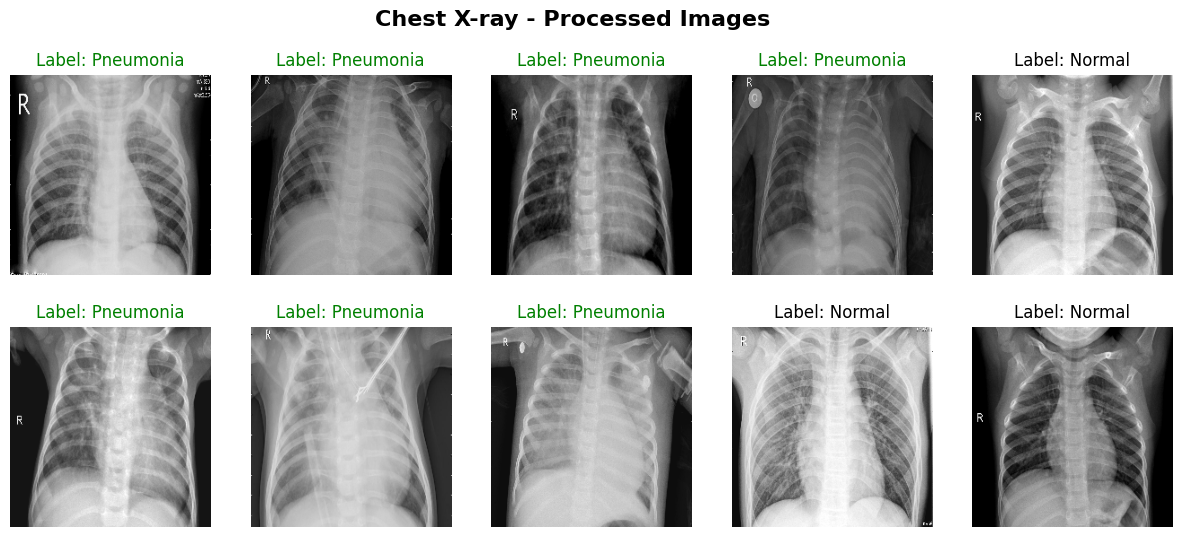

In [ ]:
# checking one batch from training dataset after preprocessing
for images, labels in training_ds.take(1):
    plt.figure(figsize=(15, 6))
    plt.suptitle('Chest X-ray - Processed Images', fontsize=16, fontweight='bold', ha='center')
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        if labels[i] == 0:
            plt.title(f"Label: Normal", color='black')
        else:
            plt.title(f"Label: Pneumonia", color='green')
        plt.axis('off')
plt.show()

**2.3 Class Weights**

Since data augmentation alone is not optimal to treat class imbalances, class weights are needed to compensate the imbalance in the dataset.

By assigning higher weights to the minority class (Normal) and lower weights to the majority class (Pneumonia), the algorithm can be encouraged to pay more attention to the minority class during training.

# 3. Modelling: Conventional CNN

**3.1 Defining the Model Architechture**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.1 Define model Conventional CNN Model Architechture
#--------------------------------------------------------------------------------------#
input_shape= (224, 224, 3)

keras.backend.clear_session()

conv_cnn_model = tf.keras.models.Sequential([
    #tf.keras.Input(shape=(200, 200, 3)),
    Conv2D(32 , (3,3) , strides = 1 ,padding = 'same', activation = 'relu',input_shape = input_shape),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    Conv2D(64 , (3,3) , strides = 1 , padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),

    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dropout(0.2),
    Dense(units = 1 , activation = 'sigmoid')
])


# Load Model Summary
conv_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

**3.2 Compile Model with Optimizer**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.2 Compile Model and Obtain Summary
#--------------------------------------------------------------------------------------#
learn_rate = 0.01
conv_cnn_model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=learn_rate)
                      , metrics='binary_accuracy')
print('Step: Model Compilation complete.')

Step: Model Compilation complete.


**3.3 Setting Callbacks**

**EarlyStopping** - prevent overfitting by stopping the training process when the validation loss fails to improve for a certain number of epochs (consecutive training iterations).

**ReduceLROnPlateau** - addresses the situation where the training process gets stuck in a local minimum (not the global minimum) and validation loss stops decreasing.

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.3 Setting VGG16 Callbacks List
#--------------------------------------------------------------------------------------#
# setting checkpoint paths
checkpoint_filepath_1 = '/tmp/checkpoint1'
checkpoint_directory_1 = os.path.dirname(checkpoint_filepath_1)

cnn_callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose = 1),
    ModelCheckpoint(filepath=checkpoint_filepath_1, monitor='val_loss',mode='min', save_weights_only=True, save_best_only=True)
]
print('Step: Setting Callbacks and Checkpoints complete.')

Step: Setting Callbacks and Checkpoints complete.


**3.4 Model Training Phase**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.4 Model Training
#--------------------------------------------------------------------------------------#
%%time
cnn_history = conv_cnn_model.fit(training_ds, validation_data=validation_ds,
            epochs=30,
            callbacks=cnn_callbacks, verbose=1)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 54s 335ms/step - loss: 3.2982 - binary_accuracy: 0.8343 - val_loss: 0.2498 - val_binary_accuracy: 0.8965 - lr: 0.0100
Epoch 2/30
129/129 [==============================] - 10s 76ms/step - loss: 0.2475 - binary_accuracy: 0.8929 - val_loss: 0.3211 - val_binary_accuracy: 0.8646 - lr: 0.0100
Epoch 3/30
128/129 [============================>.] - ETA: 0s - loss: 0.2667 - binary_accuracy: 0.8823
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
129/129 [==============================] - 9s 71ms/step - loss: 0.2665 - binary_accuracy: 0.8824 - val_loss: 1.5284 - val_binary_accuracy: 0.7361 - lr: 0.0100
Epoch 4/30
129/129 [==============================] - 10s 78ms/step - loss: 0.1918 - binary_accuracy: 0.9251 - val_loss: 0.3480 - val_binary_accuracy: 0.8771 - lr: 0.0020
Epoch 5/30
129/129 [==============================] - 9s 72ms/step - loss: 0.1724 - binary_accuracy: 0.9341 - val_loss: 0.2002 - val_binary_accuracy

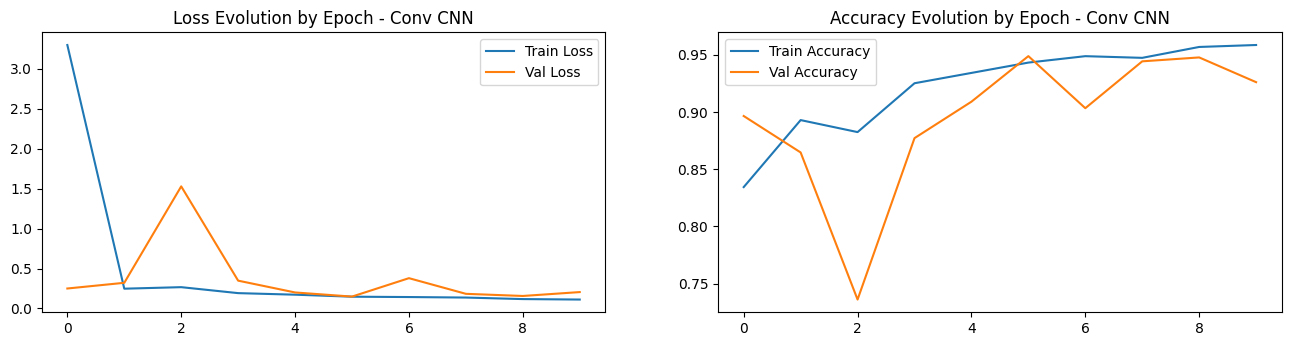

In [ ]:
mat.rc_file_defaults() #clear sns default

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution by Epoch - Conv CNN')

plt.subplot(2, 2, 2)
plt.plot(cnn_history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_binary_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution by Epoch - Conv CNN')
plt.show()

In [ ]:
### Load Weights
conv_cnn_model.load_weights(checkpoint_filepath_1)
print('Step: Loading Weights complete.')

Step: Loading Weights complete.


In [ ]:
# Function to evaluate loss and accuracy of a model on a dataset
def evaluate_model_loss_accuracy(dataset=None, model=None, split_name='Train'):
    loss, accuracy = model.evaluate(dataset, verbose=2)
    print(f'\n{split_name}: \n' + '+' * 55)
    print("loss: {:5.2f}%".format(100 * loss))
    print("accuracy: {:5.2f}%".format(100 * accuracy))
    print('\n')

# get model accuracy and loss
evaluate_model_loss_accuracy(training_ds, conv_cnn_model, 'Train')
evaluate_model_loss_accuracy(validation_ds, conv_cnn_model,'Validation')
evaluate_model_loss_accuracy(testing_ds, conv_cnn_model,'Testing')

print('Step: Evaluate Model Accuracy and Loss complete.')

129/129 - 5s - loss: 0.1080 - binary_accuracy: 0.9573 - 5s/epoch - 37ms/step

Train: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss: 10.80%
accuracy: 95.73%


28/28 - 1s - loss: 0.1484 - binary_accuracy: 0.9488 - 662ms/epoch - 24ms/step

Validation: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss: 14.84%
accuracy: 94.88%


28/28 - 7s - loss: 0.1508 - binary_accuracy: 0.9499 - 7s/epoch - 256ms/step

Testing: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss: 15.08%
accuracy: 94.99%


Step: Evaluate Model Accuracy and Loss complete.


In [ ]:
# clear tf session
tf.keras.backend.clear_session()

#saving model
conv_cnn_model.save('conv_model.keras')

# Load model
cnn_model_path= 'conv_model.keras'
loaded_cnn_model_1 = tf.keras.models.load_model(cnn_model_path)

print('Step: Saving and Loading Model complete.')

Step: Saving and Loading Model complete.


**3.5 Predictions on Test Data**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.5 Model Predictions on Test Data
#--------------------------------------------------------------------------------------#
# function to predict and evaluate
def get_model_predictions(model, dataset):
    y_actual = []         # actual labels
    y_predicted = []      # predicted labels

    # Loop to get actual and predicted labels from dataset
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_actual.extend(label.numpy())
        y_predicted.extend(np.round(predictions).flatten())

    # generate classification report
    class_report = classification_report(y_actual, y_predicted, target_names=['normal', 'pneumonia'])
    return class_report, y_actual, y_predicted

# Call Function to Predict on Test Data and Generate Classification Report
class_report_v1, y_actual, y_predicted = get_model_predictions(conv_cnn_model, testing_ds)
print("Base CNN Model - Classification Report (Test) \n=================================================================")
print(class_report_v1)

Base CNN Model - Classification Report (Test) 
              precision    recall  f1-score   support

      normal       0.89      0.92      0.91       237
   pneumonia       0.97      0.96      0.97       641

    accuracy                           0.95       878
   macro avg       0.93      0.94      0.94       878
weighted avg       0.95      0.95      0.95       878



**3.6 Performance Evaluation on Base CNN Model**

In [ ]:
#--------------------------------------------------------------------------------------#
# 3.6 Performance Evaluation
#--------------------------------------------------------------------------------------#
def evaluate_model_performance(model, y_actual, y_predicted, model_name_str):
    # Get confusion matrix
    model_confusion_matrix = confusion_matrix(y_actual, y_predicted)

    #Plot confusion_matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(model_confusion_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'{model_name_str} Model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Extract TP, FP, TN, FN
    TN, FP, FN, TP = model_confusion_matrix.ravel()
    print('---------------------------------------------------------------------------------')
    print(f"Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: {FP}")
    print(f"Normal cases incorrectly classified as Normal, its actually Pneumonia: {FN}")
    print('\n---------------------------------------------------------------------------------')

    # Calculate performance metrics for each model and return
    model_metrics = {
            'Model': [f'{model_name_str}'],
            'Accuracy': [round(accuracy_score(y_actual, y_predicted) * 100, 2)],
            'Precision': [round(precision_score(y_actual, y_predicted) * 100, 2)],
            'Recall': [round(recall_score(y_actual, y_predicted) * 100, 2)],
            'F1-Score': [round(f1_score(y_actual, y_predicted) * 100, 2)],
            'FP': [FP],
            'FN': [FN],
            'TP': [TP],
            'TN': [TN]
    }
    # Create a DataFrame from the list of dictionaries
    perf_metrics_df = pd.DataFrame(model_metrics)

    # Return the DataFrame
    return perf_metrics_df

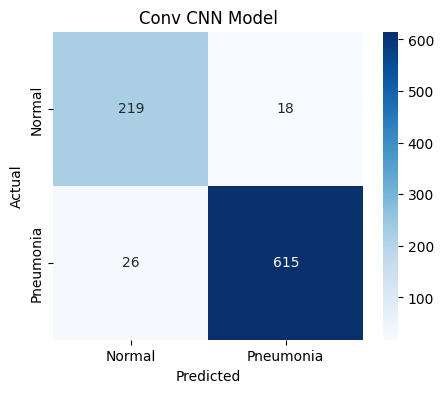

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 18
Normal cases incorrectly classified as Normal, its actually Pneumonia: 26

---------------------------------------------------------------------------------
Conventional CNN Model Performance:

      Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  Conv CNN     94.99      97.16   95.94     96.55  18  26  615  219

---------------------------------------------------------------------------------


In [ ]:
# Get Metrics for CNN Base Model
cnn_performance_df = evaluate_model_performance(conv_cnn_model, y_actual, y_predicted, 'Conv CNN')
print('Conventional CNN Model Performance:\n')
print(cnn_performance_df)
print('\n---------------------------------------------------------------------------------')

AUC-ROC: 0.9417445052232469


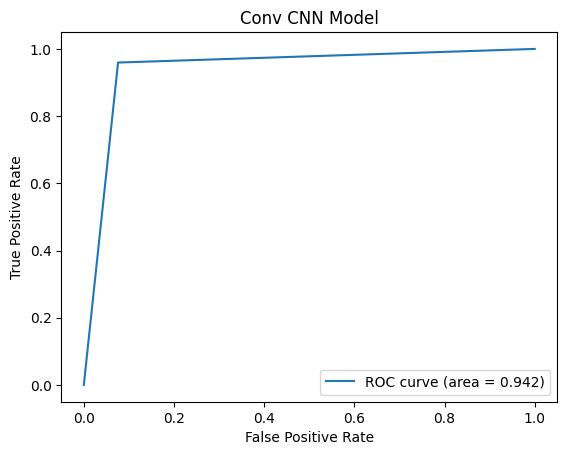

In [ ]:
# Plot the AUC-ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_actual, y_predicted, model_name_str):
  # Calculate ROC AUC score
  auc_score = roc_auc_score(y_actual, y_predicted)
  print("AUC-ROC:", auc_score)

  # Calculate false positive rate (fpr) and true positive rate (tpr)
  FPR, TPR, _ = roc_curve(y_actual, y_predicted)

  # Plot the ROC curve
  plt.plot(FPR, TPR, label='ROC curve (area = %0.3f)' % auc_score)
  plt.title(f'{model_name_str} Model')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

  return round(auc_score, 3)

# CALL function to plot auc-roc curve
cnn_auc = plot_roc_curve(y_actual, y_predicted, 'Conv CNN')

In [ ]:
# Add the AUC column to the DataFrame
cnn_performance_df['AUC'] = cnn_auc
cnn_performance_df

,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,Conv CNN,94.99,97.16,95.94,96.55,18,26,615,219,0.942


# 4. Modelling: Pretrained Model - VGG16 (Transfer Learning)

**4.1 Defining the Model Architecture**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.1 Define VGG16 Model Architecture
#--------------------------------------------------------------------------------------#

# define libraries
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# clear tf session
tf.keras.backend.clear_session()

# Load VGG16, input shape = (224,224,3)
base_pretrained_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

# Build model on top of VGG16
vgg16_cnn_model = tf.keras.Sequential()

# add the vgg16 base model
vgg16_cnn_model.add(base_pretrained_model)

# add flatten and dense layers
#vgg16_cnn_model.add(GlobalAveragePooling2D())
vgg16_cnn_model.add(Flatten())
vgg16_cnn_model.add(Dense(198, activation='relu'))
vgg16_cnn_model.add(Dense(128, activation='relu'))
vgg16_cnn_model.add(Dropout(0.2))
vgg16_cnn_model.add(Dense(1, activation='sigmoid'))

# freeze the weights of the layers in base vgg16 model, so that they will not be updated during the training process.
for layer in base_pretrained_model.layers:
    layer.trainable = False

# display model architechture
vgg16_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 198)               4967622   
                                                                 
 dense_1 (Dense)             (None, 128)               25472     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19707911 (75.18 MB)
Trainable params: 4993

**4.2 Compile Model with Optimizer**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.2 Compile Model with Optimizer
#--------------------------------------------------------------------------------------#

# set hyperparameter constants
vgg_learn_rate_v1 = 0.01  # default 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=vgg_learn_rate_v1)

# compile model
vgg16_cnn_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics='binary_accuracy')
print('Step: Pretrained Model Compilation complete.')

Step: Pretrained Model Compilation complete.


**4.3 Setting Callbacks**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.3 Set Callbacks list
#--------------------------------------------------------------------------------------#
# setting checkpoint paths
checkpoint_filepath_2 = '/tmp/checkpoint2'
checkpoint_directory_2 = os.path.dirname(checkpoint_filepath_2)

vgg16_callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose = 1),
    ModelCheckpoint(filepath=checkpoint_filepath_2, monitor='val_loss',mode='min', save_weights_only=True, save_best_only=True)
]
print('Step: VGG16 - Setting Callbacks and Checkpoints complete.')

Step: VGG16 - Setting Callbacks and Checkpoints complete.


**4.4 Model Training Phase**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.4 Training Pretrained Model
#--------------------------------------------------------------------------------------#
%%time
vgg16_history = vgg16_cnn_model.fit(training_ds, validation_data=validation_ds,
                                    epochs=30, callbacks=vgg16_callbacks, verbose=1)
print('Step: Model Training/Fitting complete.')

Epoch 1/30
129/129 [==============================] - 25s 173ms/step - loss: 1.3923 - binary_accuracy: 0.9002 - val_loss: 0.2039 - val_binary_accuracy: 0.9226 - lr: 0.0100
Epoch 2/30
129/129 [==============================] - 20s 151ms/step - loss: 0.1311 - binary_accuracy: 0.9558 - val_loss: 0.1804 - val_binary_accuracy: 0.9272 - lr: 0.0100
Epoch 3/30
129/129 [==============================] - 20s 152ms/step - loss: 0.1050 - binary_accuracy: 0.9651 - val_loss: 0.1446 - val_binary_accuracy: 0.9511 - lr: 0.0100
Epoch 4/30
129/129 [==============================] - 20s 154ms/step - loss: 0.0798 - binary_accuracy: 0.9727 - val_loss: 0.1085 - val_binary_accuracy: 0.9636 - lr: 0.0100
Epoch 5/30
129/129 [==============================] - 20s 152ms/step - loss: 0.0772 - binary_accuracy: 0.9732 - val_loss: 0.2097 - val_binary_accuracy: 0.9329 - lr: 0.0100
Epoch 6/30
128/129 [============================>.] - ETA: 0s - loss: 0.0630 - binary_accuracy: 0.9773
Epoch 6: ReduceLROnPlateau reducing l

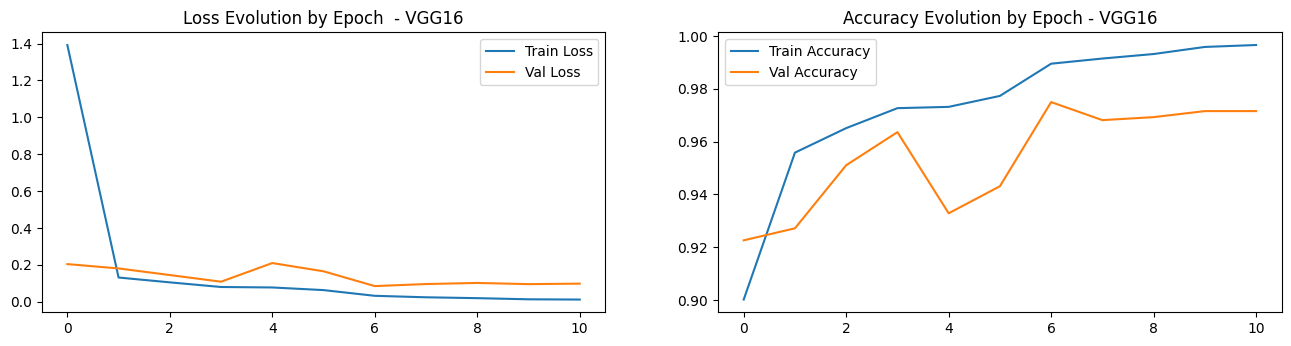

129/129 - 16s - loss: 0.0217 - binary_accuracy: 0.9937 - 16s/epoch - 124ms/step

Train: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss:  2.17%
accuracy: 99.37%


28/28 - 3s - loss: 0.0847 - binary_accuracy: 0.9750 - 3s/epoch - 125ms/step

Validation: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss:  8.47%
accuracy: 97.50%


28/28 - 4s - loss: 0.1180 - binary_accuracy: 0.9692 - 4s/epoch - 128ms/step

Testing: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss: 11.80%
accuracy: 96.92%


Step: Evaluate Model Accuracy and Loss complete.


In [ ]:
# plot accuracy and loss evolution for VGG16 model
def plot_history(vgg16_hist, model, model_name):
  plt.figure(figsize=(16, 8))

  plt.subplot(2, 2, 1)
  plt.plot(vgg16_hist.history['loss'], label='Train Loss')
  plt.plot(vgg16_hist.history['val_loss'], label='Val Loss')
  plt.legend()
  plt.title(f'Loss Evolution by Epoch  - {model_name}')

  plt.subplot(2, 2, 2)
  plt.plot(vgg16_hist.history['binary_accuracy'], label='Train Accuracy')
  plt.plot(vgg16_hist.history['val_binary_accuracy'], label='Val Accuracy')
  plt.legend()
  plt.title(f'Accuracy Evolution by Epoch - {model_name}')
  plt.show()

  # get model accuracy and loss
  evaluate_model_loss_accuracy(training_ds, model, 'Train')
  evaluate_model_loss_accuracy(validation_ds, model, 'Validation')
  evaluate_model_loss_accuracy(testing_ds, model, 'Testing')

  print('Step: Evaluate Model Accuracy and Loss complete.')

# plot the accuracy and loss evol
plot_history(vgg16_history, vgg16_cnn_model, 'VGG16')

In [ ]:
### Load Weights
vgg16_cnn_model.load_weights(checkpoint_filepath_2)
print('Step: Loading Weights complete.')

# clear tf session
tf.keras.backend.clear_session()

#saving model
vgg16_cnn_model.save('vgg16_model_v1.keras')

# Load model
vgg16_v1_model_path = 'vgg16_model_v1.keras'
loaded_vgg16_model_1 = tf.keras.models.load_model(vgg16_v1_model_path)

print('Step: Saving and Loading Model complete.')

Step: Loading Weights complete.
Step: Saving and Loading Model complete.


**4.5 Predictions on Test Data**

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.5 Model Predictions on Test Data
#--------------------------------------------------------------------------------------#
# Call Function to Predict on Test Data and Generate Classification Report
class_report_vgg16_v1, y_actual_vgg16, y_predicted_vgg16 = get_model_predictions(vgg16_cnn_model, testing_ds)
print("VGG16 Pre-trained Model - Classification Report \n=================================================================")
print(class_report_vgg16_v1)

print('\nStep: Predicting on Test Dataset complete.')

VGG16 Pre-trained Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.93      0.96      0.94       237
   pneumonia       0.99      0.97      0.98       641

    accuracy                           0.97       878
   macro avg       0.96      0.97      0.96       878
weighted avg       0.97      0.97      0.97       878


Step: Predicting on Test Dataset complete.


**4.6 Performance Evaluation on VGG16 Pretrained Model**

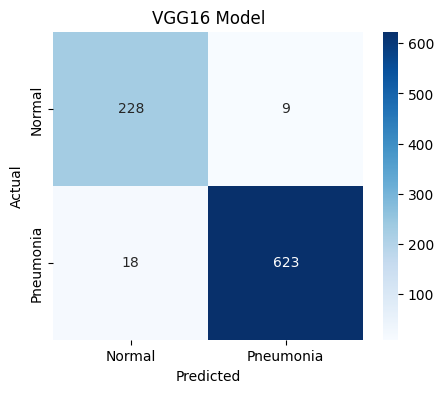

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 9
Normal cases incorrectly classified as Normal, its actually Pneumonia: 18

---------------------------------------------------------------------------------
Pretrained Model Performance (VGG16):

   Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  VGG16     96.92      98.58   97.19     97.88   9  18  623  228

---------------------------------------------------------------------------------
AUC-ROC: 0.9669720966053832


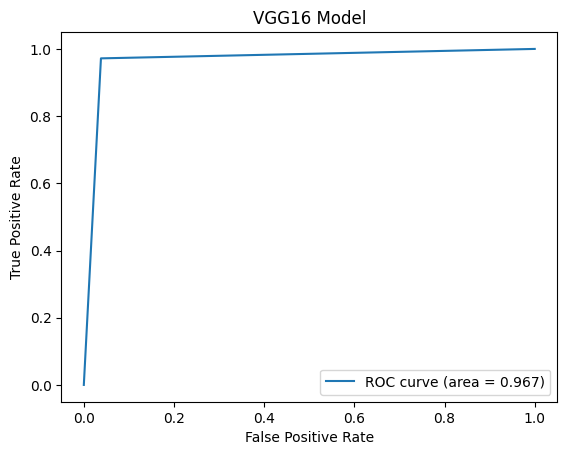

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.6 Performance Evaluation
#--------------------------------------------------------------------------------------#
# Get Metrics for VGG16 ModelS
vgg16_performance_df = evaluate_model_performance(vgg16_cnn_model, y_actual_vgg16, y_predicted_vgg16, 'VGG16')
print('Pretrained Model Performance (VGG16):\n')
print(vgg16_performance_df)
print('\n---------------------------------------------------------------------------------')

# CALL function to plot auc-roc curve
vgg16_auc = plot_roc_curve(y_actual_vgg16, y_predicted_vgg16, 'VGG16')

In [ ]:
# Add the AUC column to the DataFrame
vgg16_performance_df['AUC'] = vgg16_auc
vgg16_performance_df

,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,VGG16,96.92,98.58,97.19,97.88,9,18,623,228,0.967


In [ ]:
#--------------------------------------------------------------------------------------#
# CONCAT METRICS OF 2 MODELS
#--------------------------------------------------------------------------------------#
# Concatenate the DataFrames
merged_metrics_df = pd.concat([vgg16_performance_df, cnn_performance_df])

# Print the merged DataFrame
merged_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,VGG16,96.92,98.58,97.19,97.88,9,18,623,228,0.967
0,Conv CNN,94.99,97.16,95.94,96.55,18,26,615,219,0.942


In [ ]:
# del merged_metrics_df
# del merged_metrics_tuned

# 5. Hyperparameter Tuning on Pretrained Model - VGG16

**5.1 Define Hyperparameter list**


In [ ]:
#--------------------------------------------------------------------------------------#
# 5.1 Define Hyperparameter list
#--------------------------------------------------------------------------------------#
hyperparameter_array = [
    {'learn_rate': 0.01, 'dropout': 0.2, 'fc_dense_1': 198, 'fc_dense_2': 128, 'global_pool': True},
    {'learn_rate': 1e-3, 'dropout': 0.4, 'fc_dense_1': 198, 'fc_dense_2': 128, 'global_pool': False}
]

In [ ]:
#--------------------------------------------------------------------------------------#
# 5.2 Create Dynamic VGG16 Model Architecture - for iterative hyperparameter tuning
#--------------------------------------------------------------------------------------#
def create_vgg16_model(vgg_learn_rate, dropout_rate, fc_dense_1, fc_dense_2, global_pool=False):
  # Load VGG16, input shape = (224,224,3)
  base_pretrained_model_hp = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

  # Build model on top of VGG16
  vgg16_cnn_model_hp = tf.keras.Sequential()

  # add the vgg16 base model (feature extraction)
  vgg16_cnn_model_hp.add(base_pretrained_model_hp)

  # optionally add a global pooling layer to see if it would improve perf
  if global_pool == True:
    vgg16_cnn_model_hp.add(GlobalAveragePooling2D())

  # add classification layers
  vgg16_cnn_model_hp.add(Flatten())
  vgg16_cnn_model_hp.add(Dense(fc_dense_1, activation='relu'))
  vgg16_cnn_model_hp.add(Dense(fc_dense_2, activation='relu'))
  vgg16_cnn_model_hp.add(Dropout(dropout_rate))

  # final output layer
  vgg16_cnn_model_hp.add(Dense(1, activation='sigmoid'))

  # freeze the weights of the layers in base vgg16 model, so that they will not be updated during the training process.
  for layer in base_pretrained_model_hp.layers:
      layer.trainable = False

  # display model architechture
  vgg16_cnn_model_hp.summary()
  print('Step: Create VGG16 model complete.')

  # compile model
  optimizer = tf.keras.optimizers.Adam(learning_rate=vgg_learn_rate)
  vgg16_cnn_model_hp.compile(loss='binary_crossentropy', optimizer = optimizer, metrics='binary_accuracy')

  #return model
  return vgg16_cnn_model_hp
  print('Step: Pretrained Model Compilation complete.')


Hyperparameter Training Combination Used: 
{'learn_rate': 0.01, 'dropout': 0.2, 'fc_dense_1': 198, 'fc_dense_2': 128, 'global_pool': True}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 198)               101574    
                                                                 
 dense_1 (Dense)             (None, 128)               25472     
                                                

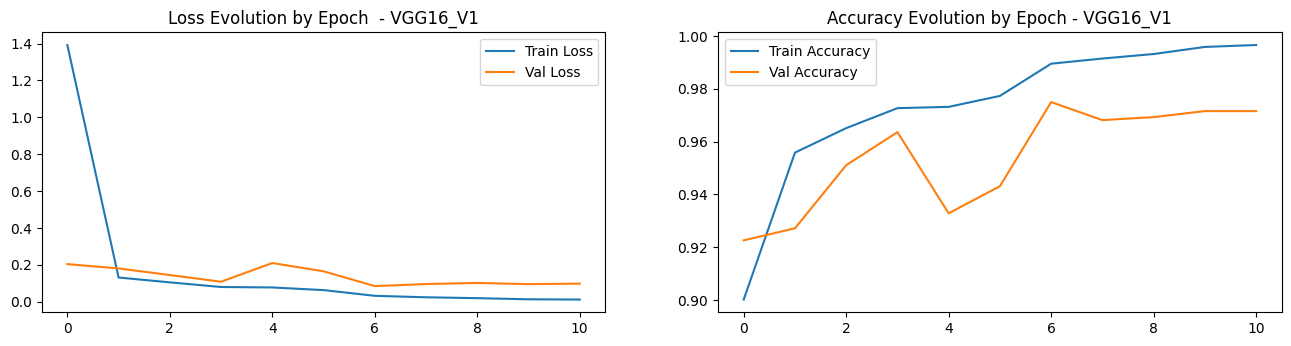

129/129 - 18s - loss: 0.0995 - binary_accuracy: 0.9658 - 18s/epoch - 139ms/step

Train: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss:  9.95%
accuracy: 96.58%


28/28 - 4s - loss: 0.1237 - binary_accuracy: 0.9522 - 4s/epoch - 136ms/step

Validation: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss: 12.37%
accuracy: 95.22%


28/28 - 4s - loss: 0.1094 - binary_accuracy: 0.9567 - 4s/epoch - 133ms/step

Testing: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss: 10.94%
accuracy: 95.67%


Step: Evaluate Model Accuracy and Loss complete.
VGG16_V1 Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.94      0.90      0.92       237
   pneumonia       0.96      0.98      0.97       641

    accuracy                           0.96       878
   macro avg       0.95      0.94      0.94       878
weighted avg       0.96      0.96      0.96       878


Step: Predicting on Test Dataset complete.


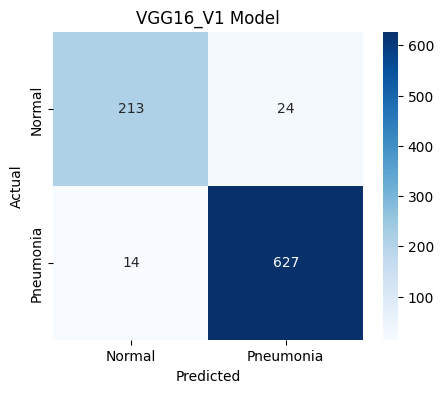

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 24
Normal cases incorrectly classified as Normal, its actually Pneumonia: 14

---------------------------------------------------------------------------------
Pretrained Model Performance (VGG16_V1):

      Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  VGG16_V1     95.67      96.31   97.82     97.06  24  14  627  213

---------------------------------------------------------------------------------
AUC-ROC: 0.9384466517901222


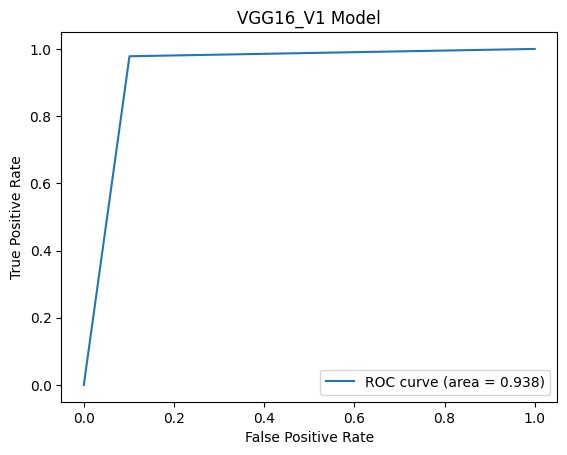

Pretrained Model Performance (VGG16_V1):


---------------------------------------------------------------------------------
      Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN    AUC
0     VGG16     96.92      98.58   97.19     97.88   9  18  623  228  0.967
0  Conv CNN     94.99      97.16   95.94     96.55  18  26  615  219  0.942
0  VGG16_V1     95.67      96.31   97.82     97.06  24  14  627  213  0.938

Step: Hyperparameter Tuning of VGG16 models 1 complete.

Hyperparameter Training Combination Used: 
{'learn_rate': 0.001, 'dropout': 0.4, 'fc_dense_1': 198, 'fc_dense_2': 128, 'global_pool': False}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                      

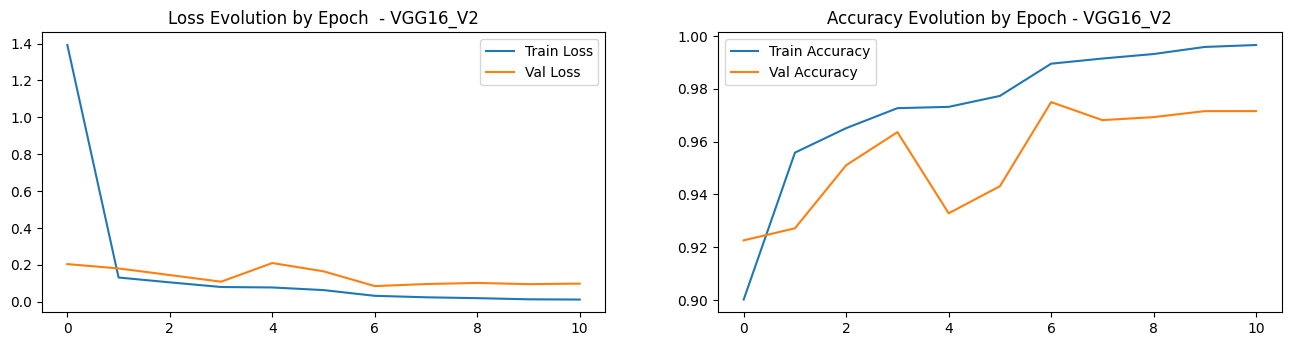

129/129 - 16s - loss: 0.0113 - binary_accuracy: 0.9956 - 16s/epoch - 126ms/step

Train: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss:  1.13%
accuracy: 99.56%


28/28 - 4s - loss: 0.0815 - binary_accuracy: 0.9704 - 4s/epoch - 129ms/step

Validation: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss:  8.15%
accuracy: 97.04%


28/28 - 4s - loss: 0.1061 - binary_accuracy: 0.9715 - 4s/epoch - 128ms/step

Testing: 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
loss: 10.61%
accuracy: 97.15%


Step: Evaluate Model Accuracy and Loss complete.
VGG16_V2 Model - Classification Report 
              precision    recall  f1-score   support

      normal       0.95      0.95      0.95       237
   pneumonia       0.98      0.98      0.98       641

    accuracy                           0.97       878
   macro avg       0.96      0.96      0.96       878
weighted avg       0.97      0.97      0.97       878


Step: Predicting on Test Dataset complete.


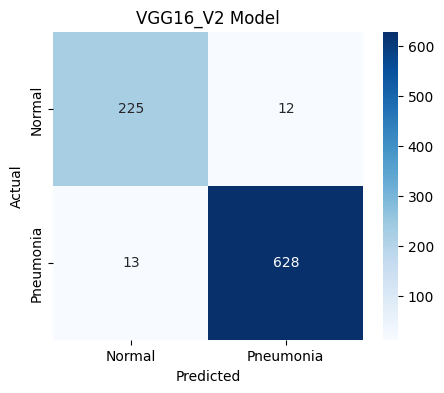

---------------------------------------------------------------------------------
Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 12
Normal cases incorrectly classified as Normal, its actually Pneumonia: 13

---------------------------------------------------------------------------------
Pretrained Model Performance (VGG16_V2):

      Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN
0  VGG16_V2     97.15      98.12   97.97     98.05  12  13  628  225

---------------------------------------------------------------------------------
AUC-ROC: 0.9645431386875728


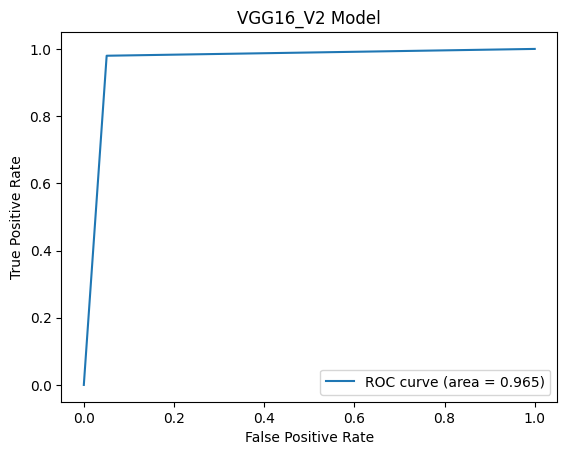

Pretrained Model Performance (VGG16_V2):


---------------------------------------------------------------------------------
      Model  Accuracy  Precision  Recall  F1-Score  FP  FN   TP   TN    AUC
0     VGG16     96.92      98.58   97.19     97.88   9  18  623  228  0.967
0  Conv CNN     94.99      97.16   95.94     96.55  18  26  615  219  0.942
0  VGG16_V1     95.67      96.31   97.82     97.06  24  14  627  213  0.938
0  VGG16_V2     97.15      98.12   97.97     98.05  12  13  628  225  0.965

Step: Hyperparameter Tuning of VGG16 models 2 complete.


In [ ]:
#--------------------------------------------------------------------------------------#
# 5.3 Iterative Hyperparameter tuning
#--------------------------------------------------------------------------------------#
loop_count = 0 # model count
merged_metrics_tuned = merged_metrics_df #carryover previous model metrics values

for params in hyperparameter_array:
  global_pool = params['global_pool']
  learn_rate = params['learn_rate']
  dropout = params['dropout']
  fc_dense_1 = params['fc_dense_1']
  fc_dense_2 = params['fc_dense_2']
  print(f'\nHyperparameter Training Combination Used: \n{params}')

  loop_count = loop_count + 1 #increment loop
  model_name_hp = f'VGG16_V{loop_count}'

  # clear tf session
  tf.keras.backend.clear_session()

  # create model
  vgg_tuned_model = create_vgg16_model(learn_rate, dropout, fc_dense_1, fc_dense_2, global_pool)

  #set callbacks list
  vgg16_callbacks_hp = [
      EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose = 1),
      ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose = 1),
      ModelCheckpoint(filepath=f'vgg_best_model{model_name_hp}.h5', monitor='val_loss',mode='min', save_weights_only=True, save_best_only=True)]

  #fit model
  vgg16_history_hp = vgg_tuned_model.fit(training_ds, validation_data=validation_ds,
                                      epochs=30, callbacks=vgg16_callbacks_hp, verbose=1)
  print('Step: Model Training/Fitting complete.')

  # plot the accuracy and loss evol
  plot_history(vgg16_history, vgg_tuned_model, model_name_hp)

  # Call Function to Predict on Test Data and Generate Classification Report
  class_report_vgg16_tuned, y_actual_hp, y_predicted_hp = get_model_predictions(vgg_tuned_model, testing_ds)
  print(f"{model_name_hp} Model - Classification Report \n=================================================================")
  print(class_report_vgg16_tuned)
  print('\nStep: Predicting on Test Dataset complete.')

  # Get Metrics for VGG16 ModelS
  tuned_vgg16_performance_df = evaluate_model_performance(vgg_tuned_model, y_actual_hp, y_predicted_hp, model_name_hp)
  print(f'Pretrained Model Performance ({model_name_hp}):\n')
  print(tuned_vgg16_performance_df)
  print('\n---------------------------------------------------------------------------------')

  # CALL function to plot auc-roc curve
  vgg_tuned_auc = plot_roc_curve(y_actual_hp, y_predicted_hp, model_name_hp)
  # Add the AUC column to the DataFrame
  tuned_vgg16_performance_df['AUC'] = vgg_tuned_auc
  print(f'Pretrained Model Performance ({model_name_hp}):\n')
  tuned_vgg16_performance_df

  # Concatenate the DataFrames
  merged_metrics_tuned = pd.concat([merged_metrics_tuned, tuned_vgg16_performance_df])
  print('\n---------------------------------------------------------------------------------')
  print(merged_metrics_tuned)

  print(f'\nStep: Hyperparameter Tuning of VGG16 models {loop_count} complete.')

# 6. Performance Comparison/Evaluation

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.1 Display Combined Performance Metrics Dataframe
#--------------------------------------------------------------------------------------#
final_metrics = merged_metrics_tuned
final_metrics.sort_values(by='Model', ascending=True)

,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,Conv CNN,94.99,97.16,95.94,96.55,18,26,615,219,0.942
0,VGG16,96.92,98.58,97.19,97.88,9,18,623,228,0.967
0,VGG16_V1,95.67,96.31,97.82,97.06,24,14,627,213,0.938
0,VGG16_V2,97.15,98.12,97.97,98.05,12,13,628,225,0.965


#### Which Models Performed best in each area?

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.2 Accuracy
#--------------------------------------------------------------------------------------#
# Get row with the highest Accuracy
print("Model with the Highest Accuracy:")
final_metrics[final_metrics['Accuracy'] == final_metrics['Accuracy'].max()]

Model with the Highest Accuracy:


,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,VGG16_V2,97.15,98.12,97.97,98.05,12,13,628,225,0.965


In [ ]:
print("Models Sorted by Accuracy:")
highestacc = final_metrics[['Model', 'Accuracy']].nlargest(4, 'Accuracy')
highestacc.sort_values(by='Accuracy', ascending=False)

Models Sorted by Accuracy:


,Model,Accuracy
0,VGG16_V2,97.15
0,VGG16,96.92
0,VGG16_V1,95.67
0,Conv CNN,94.99


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.2 F1-Score
#--------------------------------------------------------------------------------------#
# Get row with the highest F1-Score
print(f"Model with the Highest F1-Score:\n")
final_metrics[final_metrics['F1-Score'] == final_metrics['F1-Score'].max()]

Model with the Highest F1-Score:



,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,VGG16_V2,97.15,98.12,97.97,98.05,12,13,628,225,0.965


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.3 Recall
#--------------------------------------------------------------------------------------#
# Get row with the highest Recall
print(f"Model with the Highest Recall:\n")
final_metrics[final_metrics['Recall'] == final_metrics['Recall'].max()]

Model with the Highest Recall:



,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,VGG16_V2,97.15,98.12,97.97,98.05,12,13,628,225,0.965


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.4 Precision
#--------------------------------------------------------------------------------------#
# Get row with the highest Precision
print(f"Model with the Highest Precision:\n")
final_metrics[final_metrics['Precision'] == final_metrics['Precision'].max()]

Model with the Highest Precision:



,Model,Accuracy,Precision,Recall,F1-Score,FP,FN,TP,TN,AUC
0,VGG16,96.92,98.58,97.19,97.88,9,18,623,228,0.967


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.5 False Positive
#--------------------------------------------------------------------------------------#
# Get row with the lowest false postive value
print("Models with Lowest False Postives")
print("Note: Pneumonia classes incorrectly classified as Normal. \n")
lowestfp = final_metrics[['Model', 'FP', 'FN']].nsmallest(2, 'FP')
print(lowestfp.sort_values(by='FP', ascending=True))

Models with Lowest False Postives
Note: Pneumonia classes incorrectly classified as Normal. 

      Model  FP  FN
0     VGG16   9  18
0  VGG16_V2  12  13


In [ ]:
#--------------------------------------------------------------------------------------#
# 6.6 False Negatives
#--------------------------------------------------------------------------------------#
# Get row with the lowest false negative value
print("Models with Lowest False Negatives")
print("Note: Normal classes incorrectly classified as Pneumonia. \n")
lowestfp = final_metrics[['Model', 'FN', 'FP']].nsmallest(2, 'FN')
print(lowestfp.sort_values(by='FN', ascending=True))

Models with Lowest False Negatives
Note: Normal classes incorrectly classified as Pneumonia. 

      Model  FN  FP
0  VGG16_V2  13  12
0  VGG16_V1  14  24


In [ ]:
# interpolate cmap values for plots
cmap = mat.cm.Blues(np.linspace(0,1,90))
cmapblues = mat.colors.ListedColormap(cmap[10:,:-1])

cmap = mat.cm.Purples(np.linspace(0,1,90))
cmappurples = mat.colors.ListedColormap(cmap[10:,:-1])

cmap = mat.cm.Oranges(np.linspace(0,1,97))
cmaporanges = mat.colors.ListedColormap(cmap[10:,:-1])

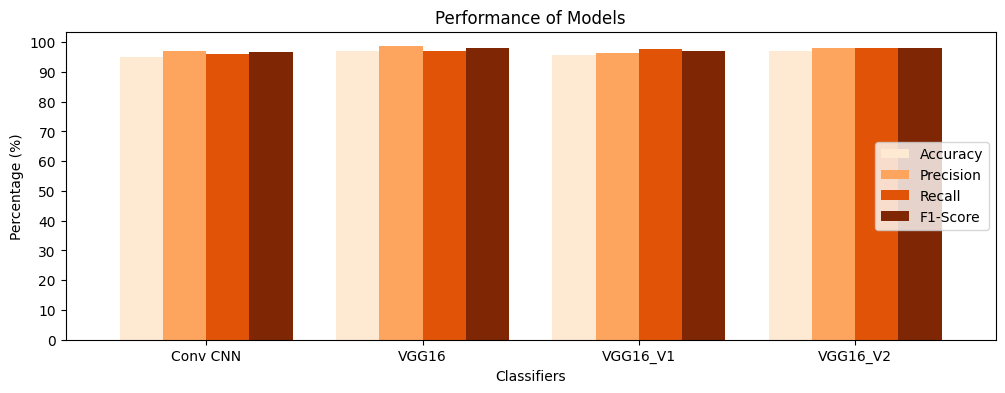

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.7 Visualize: Comparison of Model Performances
#--------------------------------------------------------------------------------------#
# plot a graph to compare metrics visually
eval_metrics = final_metrics.iloc[:,0:5]
eval_metrics.sort_values(by="Model", ascending=True, inplace=True)
#eval_metrics.reset_index(drop=True, inplace=True

metrics_plot = eval_metrics.plot.bar(cmap = cmaporanges,
                figsize=(12, 4),
                width = 0.8,
                grid=False)
metrics_plot.set_xticklabels(eval_metrics['Model'])

plt.xticks(rotation=0)
plt.yticks(np.arange(0,101, 10))        #calculate a range of numbers from 0, 100 with a step 10
plt.ylabel("Percentage (%)")
plt.xlabel("Classifiers")
#plt.xlabel("Model-Vectorizer Performance")
plt.legend(loc='center right', ncols=1)
plt.title(f'Performance of Models')
plt.show()

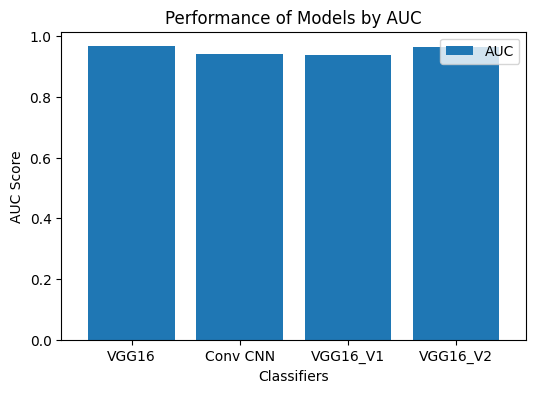

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.7 Visualize: Comparison of Model Performances by AUC
#--------------------------------------------------------------------------------------#
# plot a graph to compare metrics visually
eval_AUC = final_metrics
eval_AUC = final_metrics[['Model','AUC']]
eval_AUC.sort_values(by="Model", ascending=True)

metrics_plot = eval_AUC.plot.bar(figsize=(6, 4), width = 0.8, grid=False)
metrics_plot.set_xticklabels(eval_AUC['Model'])
plt.xticks(rotation=0)
plt.ylabel("AUC Score")
plt.xlabel("Classifiers")
plt.title(f'Performance of Models by AUC')
plt.legend(loc='best', ncols=1)
plt.show()

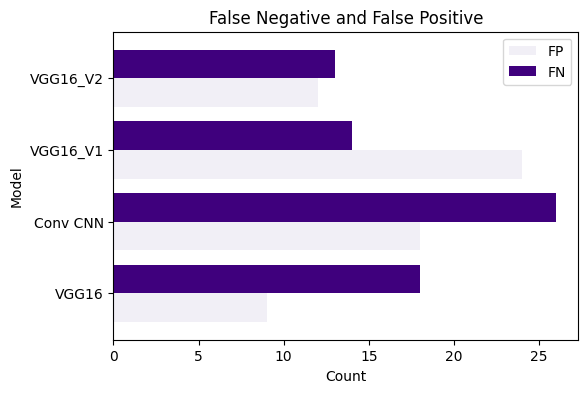

In [ ]:
# plot the false positive and false negative
false_rates = final_metrics
false_rates = false_rates[['Model','FP','FN']]
false_rates.sort_values(by="Model", ascending=True)

# vizualize results in a bar chart
false_rates.plot(x='Model',
        kind='barh',
        stacked=False,
        title='False Negative and False Positive',
        cmap=cmappurples,
        figsize=(6, 4),
        align='center',
        width = 0.8 )
plt.xticks(rotation=0)
#plt.xticks(np.arange(0,8, 1))
plt.xlabel("Count")
plt.legend(loc='upper right', ncols=1)
plt.show()

In [ ]:
#merged_metrics_df
eval_AUC

,Model,AUC
0,VGG16,0.967
0,Conv CNN,0.942
0,VGG16_V1,0.938
0,VGG16_V2,0.965
